# Data exploration M2

In [2]:
# pip install pandas==1.0.5

In [236]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
print('pandas version: ' + pd.__version__)

pandas version: 1.0.5


In [238]:
path_data = '/content/drive/MyDrive/Quotebank/'

In [239]:
# loop through nb_chunks_to_read chunks (if 0, through all chunks) and apply process_function to each of them
# return the result as a dataframe
def loop_chuncks(chunks, process_function, nb_chunks_to_read=0):
  i = 0
  result = []
  columns = None
  for chunk in chunks:
    processed = process_function(chunk)
    if processed is not None:
      if not isinstance(processed, pd.Series):
        columns = processed.columns
      for r in processed.values.tolist():
        result.append(r)
    i += 1
    if i == nb_chunks_to_read:
      break
  return pd.DataFrame(result, columns=columns)

In [240]:
# return the first 3 elements of a chunk
def chunck_head(chunk):
  return chunk.head(3)

In [241]:
chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
loop_chuncks(chunks, chunck_head, 1)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-28-000082,[ D ] espite the efforts of the partners to cr...,None,[],2020-01-28 08:04:05,1,"[[None, 0.7272], [Prime Minister Netanyahu, 0....",[http://israelnationalnews.com/News/News.aspx/...,E
1,2020-01-16-000088,[ Department of Homeland Security ] was livid ...,Sue Myrick,[Q367796],2020-01-16 12:00:13,1,"[[Sue Myrick, 0.8867], [None, 0.0992], [Ron Wy...",[http://thehill.com/opinion/international/4782...,E
2,2020-02-10-000142,... He (Madhav) also disclosed that the illega...,None,[],2020-02-10 23:45:54,1,"[[None, 0.8926], [Prakash Rai, 0.1074]]",[https://indianexpress.com/article/business/ec...,E


In [242]:
# return the quotes containing 'global warming'
def contains_global_warming(chunk):
  return chunk[chunk.quotation.str.contains('global warming')]

In [243]:
chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
global_warming_quotes = loop_chuncks(chunks, contains_global_warming, 10)

In [244]:
global_warming_quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
6,2020-02-07-082877,The experts tell us that we're heading for thr...,None,[],2020-02-07 05:18:00,3,"[[None, 0.8622], [Barnaby Joyce, 0.1378]]",[http://www.northerndailyleader.com.au/story/6...,E
16,2020-01-06-060566,The impact of global warming on India is unmis...,None,[],2020-01-06 19:53:14,1,"[[None, 0.9583], [El Niño, 0.0417]]",[https://timesofindia.indiatimes.com/india/201...,E
15,2020-01-27-039192,In the latest sign of global warming's grip on...,Meghan Markle,[Q3304418],2020-01-27 00:00:00,6,"[[Meghan Markle, 0.5935], [None, 0.4065]]",[https://truthout.org/articles/the-world-is-bu...,E


In [245]:
# to create automatically a list of synonym
# https://towardsdatascience.com/synonyms-and-antonyms-in-python-a865a5e14ce8
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

words = []
for syn in wordnet.synsets("warming"):
    for lm in syn.lemmas():
             words.append(lm.name())
words

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['heating',
 'warming',
 'thaw',
 'thawing',
 'warming',
 'warm',
 'warm_up',
 'warm',
 'warming',
 'calefacient',
 'warming']

In [246]:
# or do it manually
words = ['global warming', 'climate change']

In [247]:
# return the quotes containing one of the words in a list
def contains_word_in_list(chunk):
  return chunk[chunk.quotation.str.contains('|'.join(words))]

In [295]:
chunks = pd.read_json(path_data + 'quotes-2020.json.bz2', lines=True, compression='bz2', chunksize=10000)
word_in_list_quotes = loop_chuncks(chunks, contains_word_in_list, 100)

In [296]:
word_in_list_quotes.sample(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
274,2020-01-02-043370,Previous Amazon workers clash with company ove...,None,[],2020-01-02 23:07:40,1,"[[None, 0.9465], [Carlos Ghosn, 0.0535]]",[https://www.centralmaine.com/2020/01/02/wall-...,E
887,2020-04-06-043982,the government's biggest effort to combat clim...,None,[],2020-04-06 10:46:42,1,"[[None, 0.5981], [President Trump, 0.4019]]",[https://www.alternet.org/2020/04/the-administ...,E
706,2020-01-23-078388,that there was a need to step up efforts to un...,None,[],2020-01-23 16:07:00,3,"[[None, 0.6], [Christine Lagarde, 0.4]]",[http://wap.business-standard.com/article/curr...,E


In [297]:
top_speakers_topic_2020 = word_in_list_quotes.groupby(by='speaker').count().sort_values(by='quotation', ascending=False).quotation.iloc[1:11]
top_speakers_topic_2020

speaker
Bernie Sanders      22
Joaquin Phoenix     15
Larry Fink          12
Scott Morrison      10
Boris Johnson       10
Joe Biden           10
Jeff Bezos           9
Malcolm Turnbull     9
Greta Thunberg       8
Chris Kenny          7
Name: quotation, dtype: int64

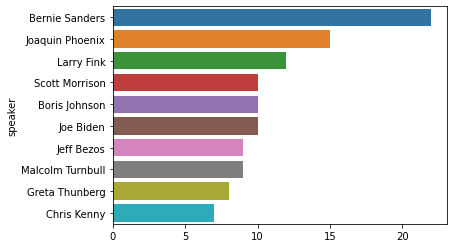

In [298]:
sns.barplot(x=top_speakers_topic_2020.values, y=top_speakers_topic_2020.index)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


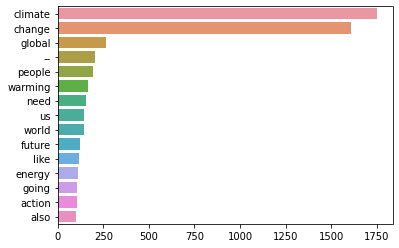

In [305]:
from nltk.corpus import stopwords
nltk.download('stopwords')

topic_words = collections.Counter()
stop_words = set(stopwords.words('english'))
for index, row in word_in_list_quotes.iterrows():
    for word in row.quotation.lower().replace(',', '').replace('.', '').split():
        if word not in stop_words:
            topic_words[word] += 1
top_topic_words = topic_words.most_common()[:15]
top_topic_words_w = [x[0] for x in top_topic_words]
top_topic_words_v = [x[1] for x in top_topic_words]
sns.barplot(x=top_topic_words_v, y=top_topic_words_w)

In [270]:
# number of quotations containing a topic through time
years = ['2015', '2016', '2017', '2018', '2019', '2020']
count_years = []
number_chunks = 10
for year in years:
  chunks = pd.read_json(path_data + 'quotes-' + year + '.json.bz2', lines=True, compression='bz2', chunksize=10000)
  count = loop_chuncks(chunks, contains_word_in_list, number_chunks).size
  count_years.append(count)
count_years

[1170, 828, 1008, 819, 1530, 1476]

Text(0.5, 1.0, 'Quotations about global warming though time')

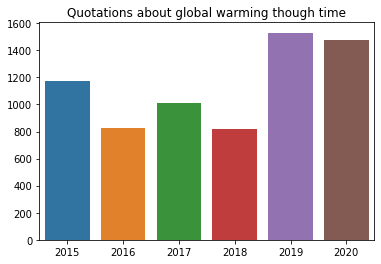

In [271]:
sns.barplot(x=years, y=count_years)
plt.title("Quotations about global warming though time")